# Case Study 01b: Building a Co-occurence Network from Doctors' Notes
---

This case study focuses on building a co-occurence network from the doctors' reports data. The goal is to learn the relationship between a set of tokens/concepts/keywords using the doctors' reports.

We use the same dataset as Case Study 01.

Run the following two cells to import all the necessary libraries and to create the folder for the data files.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pathlib
import re
import polars as pl

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['svg.fonttype'] = 'none'

import sys
sys.path.append("../")
from aladalib import chap01 as ch01
from aladalib import casestudy01 as cs01

# Create data folder for the case study
cs01.create_data_folder()

## 0. Getting the data

Link to the kaggle dataset: [https://www.kaggle.com/datasets/gauravmodi/doctors-notes/data](https://www.kaggle.com/datasets/gauravmodi/doctors-notes/data)

Download the `reports.csv` file, and copy it into the folder `data/case_study_01/`. After you have done this, run the following cell and check if it reports success.

In [3]:
cs01.check_dataset()

'Success! You can run this notebook.'

## 1. What does this dataset have?

The data is in a `.csv` file. If you do not know what that means, then take a look [here](https://en.wikipedia.org/wiki/Comma-separated_values).

The file has two columns: `medical_specialty` and `report`.
- The `medical_specialty` column contains the specialty of the doctor who wrote the report, and
- the `report` column contains the actual text of the report written down by the doctor for a particular patient.

For the purpose of this case study, we will only be using the `report` column; we will use the `medical_specialty` column only for evaluating the clustering results for us know how well our clustering algorithm has performed.

Now, let's read the reports.csv file and see what it has.

In [4]:
# Data folder and file
datadir = "data/case_study_01"
datafile = (datadir / pathlib.Path("reports.csv")).as_posix()
tokensfile = (datadir / pathlib.Path("tokens-010.txt")).as_posix()

# Read the medical records file.
medrec = pl.read_csv(datafile)

# Create the medical speciality Enum
medspec_enum = pl.Enum(medrec["medical_specialty"].unique())

# Convert the medical_specialty column to an Enum
medrec = medrec.with_columns(
    medrec["medical_specialty"].cast(medspec_enum)
)

# Convert a str column in polar to lower case, and it as a new column.
medrec = medrec.with_columns(
    report_lower=pl.col("report").str.to_lowercase()
)

---
## 2. What is a co-occurance network?

A co-occurance network is a method to represent the relationship between a set of tokens/concepts/keywords. In this network, the nodes represent the tokens/concepts/keywords, and the edges represent the relationship between them. The nature of the edge could indicate the presence or absence of a realtionship, or the strength of the relationship.

We will use the `tokens-025.txt` files for this analysis.

In [6]:
with open(tokensfile, "r") as f:
    tokens = f.read().split(',')
print("Tokens: ", tokens)
# The number of tokens.
print(f"Number of tokens: {len(tokens):3d}")

Tokens:  ['impress', 'palpitation', 'gallop', 'compare', 'nonsignificant', 'emphysema', 'noncontributory', 'fahrenheit', 'valley', 'recreational', 'collect', 'meckel', 'heartburn', 'fundoplication', 'contributory', 'subjective', 'neutrophil', 'interpret', 'clostridium', 'flatus', 'rating', 'psychological', 'huntington', 'epilepsy', 'ataxia', 'tended', 'command', 'meningioma', 'edition', 'america', 'relate', 'sprain', 'cuboid', 'predict', 'version', 'echogenic', 'discontinuity', 'intrinsically', 'subcutis', 'tendinitis', 'reoperative', 'proximate', 'plication', 'ladder', 'essure', 'ending', 'compress', 'script', 'plasty', 'fluoro']
Number of tokens:  50


We define a token-indicator vector as a binary n-vector that indicates the presence or absence of a token in a given text. Consider the following example,

**Sample Text:** "The quick brown fox jumps over the lazy dog. The dog is very lazy, but the fox is quick. The dog is friendly through; the fox cannot be trusted."

**Tokens:** ["lion", "fox", "dog", "elephant", "cat"]

The token-indicator vector is in this case is given by $\begin{bmatrix} 0 & 1 & 1 & 0 & 0 \end{bmatrix}^\top$. Note that in this case, we do not care about how many times the token occurs in the text.

In [7]:
def token_indicator(note: str, tokens: list) -> np.array:
    """Returns a binary n-vector that indicates the presence or abseence of
    each token in the note."""
    return [1 * (tok in note) for tok in tokens]

Let's try this function on some of the reports in the dataset.

In [8]:
for _row in medrec.with_row_index().sample(10).iter_rows(named=True):
    _nvec = token_indicator(_row["report_lower"], tokens)
    print(f"Row: {_row['index']:4d}", _nvec)

Row:  132 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0]
Row: 1166 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Row: 1389 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Row: 1776 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Row: 2026 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Row: 1190 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Row:  788 [0, 0, 0, 0, 0, 0, 0, 0,

Let's now generate a binary numpy array tokens as the columns and the reports as the rows. The value of each cell will be 1 or 0. Let this binary matrix be $\mathbf{O} \in \mathbb{R}^{n \times m}$ ('O' for occurance), with,
$$ o_{ij} = \begin{cases} 
0 & \quad j^{th} \text{ token is not present in the } i^{th} \text{ report.} \\
1 & \quad j^{th} \text{ token is present in the } i^{th} \text{ report.}
\end{cases}, \quad 1 \leq i \leq n, \,\, 1 \leq j \leq m 
$$ 
where, $n$ is the number of reports, and $m$ is the number of the tokens.

In [9]:
# Generate a binary dataframe with the tokens as columns and reports as rows.
tokind = np.array([token_indicator(_rep, tokens)
                   for _rep in medrec["report_lower"]])
print(f"Shape of tokind: {tokind.shape[0]:3d} x {tokind.shape[1]:3d}")

Shape of tokind: 2179 x  50


Let's say we were interested in the number of times the tokens $p$ and $q$ co-occured in these reports. This can be easily obtained using matrix algebra! We simply take the inner product of the $p^{th}$ and $q^{th}$ columns of the matrix $\mathbf{O}$. We can infact generate a new $m \times m$ matrix containing the counts of the number of times each word pair co-occured in the reports as the following,
$$ \mathbb{R}^{m \times m} \, \ni \, \mathbf{C} = \mathbf{O}^\top \mathbf{O}$$

<span style="color:#B30000">**Assignment-01b-1**: What do the elements $c_{ii}, \, 1 \leq i \leq m$ correspond to? </span>

<span style="color:#B30000">**Assignment-01b-2**: Is $\mathbf{C}$ a symmetric matrix? If it is symmetric, can you explain why it makes sense that its symmetric? If its not, explain if that makes sense. </span>


In [10]:
# The co-occurence count matrix
C = tokind.T @ tokind

Note that the count of co-occurence only makes sense relative to the number of times each of  these tokens occurs in the reports. For examples, consider the following two cases:

- **Case-1**: $\mathbf{x} = \begin{bmatrix} 1 & 1 & 1 & 1 & 1 \end{bmatrix}^\top$ and $\mathbf{y} = \begin{bmatrix} 1 & 0 & 0 & 1 & 0 \end{bmatrix}^\top$.
- **Case-2**: $\mathbf{x} = \begin{bmatrix} 1 & 0 & 0 & 1 & 0 \end{bmatrix}^\top$ and $\mathbf{y} = \begin{bmatrix} 1 & 0 & 0 & 1 & 0 \end{bmatrix}^\top$.

In both cases, $\mathbf{x}^\top\mathbf{y} = 2$, but we would agree that the two tokens corresponding to the vectors $\mathbf{x}$ and $\mathbf{y}$ co-occur in Case-2 than Case-1. So, $\mathbf{x}^\top\mathbf{y}$ does not capture the co-occurace of the tokens relative to the the occurence of the two tokens. Thsi can be done by normalizing the inner product by the corresponding lengths of the two vectors,
$$ \langle \mathbf{x}, \mathbf{y}\rangle = \frac{\mathbf{x}^\top\mathbf{y}}{\lVert \mathbf{x} \rVert_2\lVert \mathbf{y} \rVert_2}$$
where,  $\langle \mathbf{x}, \mathbf{y}\rangle$ is the $\cos$ of the angle between the vectors $\mathbf{x}$ and $\mathbf{y}$.

<span style="color:#B30000">**Assignment-01b-3**: Explain why in this particular application, $0 \leq \langle \mathbf{x}, \mathbf{y}\rangle \leq 1$, i.e. that angle between the two vectors is within $0^\circ$ and $90^\circ$.</span>

We can compute this normalized co-occurence matrix $\hat{\mathbf{C}}$ by first normalizing the columns of $\mathbf{O}$ to get $\hat{\mathbf{O}}$,
$$ \hat{\mathbf{O}} = \begin{bmatrix} \hat{\mathbf{o}}_1 & \hat{\mathbf{o}}_2 & \cdots & \hat{\mathbf{o}}_m\end{bmatrix}, \quad \hat{\mathbf{o}}_i = \begin{cases} \frac{\mathbf{o}_i}{\lVert \mathbf{o}_i \rVert_2}, & \lVert \mathbf{o}_i \rVert_2 \neq 0 \\ \mathbf{o}_i, & \lVert \mathbf{o}_i \rVert_2 = 0\end{cases} $$

<span style="color:#B30000">**Assignment-01b-4**: The matrix $\hat{\mathbf{O}}$ can be expressed the matrix $\mathbf{O}$ post-multiplied by a diagonal matrix $\mathbf{D}$. What are the elements of $\mathbf{D}$, such that $\hat{\mathbf{O}} = \mathbf{O}\mathbf{D}$. </span>

We can now obtain $\hat{\mathbf{C}}$ as the following,
$$ \hat{\mathbf{C}} = \hat{\mathbf{O}}^\top\hat{\mathbf{O}}$$

In [11]:
# Normalize the occurence matrix's columns.
O_hat = np.array([_col / np.linalg.norm(_col)
                  if np.linalg.norm(_col) != 0 else _col
                  for _col in tokind.T]).T

# Noramlized co-occurence matrix.
C_hat = O_hat.T @ O_hat
C_hat

array([[1.        , 0.10221701, 0.17490848, ..., 0.07247449, 0.03522066,
        0.11696613],
       [0.10221701, 1.        , 0.31174074, ..., 0.03066057, 0.01303769,
        0.        ],
       [0.17490848, 0.31174074, 1.        , ..., 0.0680099 , 0.        ,
        0.02328259],
       ...,
       [0.07247449, 0.03066057, 0.0680099 , ..., 1.        , 0.12941677,
        0.15628617],
       [0.03522066, 0.01303769, 0.        , ..., 0.12941677, 1.        ,
        0.10126785],
       [0.11696613, 0.        , 0.02328259, ..., 0.15628617, 0.10126785,
        1.        ]])

<span style="color:#B30000">**Assignment-01b-5**: Does it make sense that the diagonal elements of $\hat{\mathbf{C}}$ are 1? What does this mean?</span>

We can now use the off diagonal element of the matrix $\hat{\mathbf{C}}$ as a measure of the relationship between two tokens: 
- a value of 1 indicates a strong relationship, i.e. these two tokens always co-occur.
- a value of 0 indicates no relationship, i.e. the words never co-occur.

We will now use the off diagonal elements to visualize the link between the token using the following code:

In [12]:
def plot_graph(ax, C_hat, tokens):
    # Place the tokens on a unit circle with equal distance between them.
    _t = np.arange(0, 2 * np.pi, 2 * np.pi / len(tokens))
    tokenpos = np.array([np.cos(_t),
                         np.sin(_t)])
    # Let's now draw then links between them. The color of the link is determined
    # by the strength of the relationship: 0 - white, 1 - black.
    scaleconn = lambda c : np.max([0.2, np.min([1.0, 5 * c])])
    for i in range(len(tokens)):
        for j in range(i + 1, len(tokens)):
            # Check if the normalized co-occurance is 
            _conn = 1 - scaleconn(C_hat[i, j])
            ax.plot(0.98 * np.array([tokenpos[0, i], tokenpos[0, j]]),
                    0.98 * np.array([tokenpos[1, i], tokenpos[1, j]]),
                    lw=0.75 * (1 - _conn), color=f"{_conn}",
                    zorder=int(10 * (1 - _conn)))
    ax.scatter(tokenpos[0], tokenpos[1], marker='o', s=25,
               edgecolor="tab:red", facecolor='white')
    # Display the token text.
    # Add text labels next to each node
    for i, token in enumerate(tokens):
        # Check the x position and determine the horizonal alignment.
        _xpos, _ypos = (np.round(tokenpos[0, i], decimals=2),
                        np.round(tokenpos[1, i], decimals=2))
        _ha, _dx = (('left', 0.04) if _xpos > 0
                    else ('right', -0.04) if _xpos < 0 else ('center', 0))
        _dy = 0.1 * _ypos
        ax.text(tokenpos[0, i] + _dx, tokenpos[1, i] + _dy, token,
                fontsize=10, ha=_ha, va='center', color='black',
                rotation=np.sign(_xpos) * _ypos * 25)

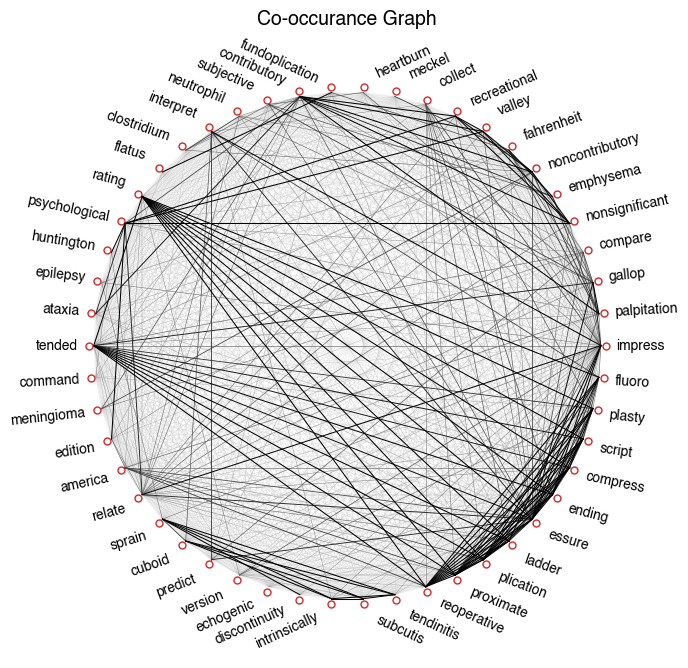

In [12]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plot_graph(ax, C_hat, tokens)
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_title("Co-occurance Graph", fontsize=14)
plt.tight_layout()


In the above graph, the thick black lines between two nodes (tokens) indicates that the two tokens co-occur more often than the nodes connected by a thin lighter line. This might mean that these tokens are somehow related conceptually. For example, there is a dark thick line between `sprain` and `tendonitis`, `fundoplication` and `flatus`, etc. (search the meanings of these terms if you do not know what they mean); this makes sense. There are other thick lines that may not be because they are medically related, but could be the result of various other factors, such as the choice of the tokens, the nature of the language, the exact clinical condition being described, etc. (e.g. the thick line between `relate` and `impress`).

An important point to keep in mind is that the interpretation of this graph is strongly determined by the how we quantified co-occurance. Depending on the choice of this method, we could have different graphs for the same dataset and tokens.

Building on the discussion presented in the current case study, you are required to carry out the following exercises as part of the assignment for this case study.

<span style="color:#B30000">

**Assignment-01b-6**: We have used a binary occurance matrix to quantify the co-occurnace of the tokens. We could have instead used the count vectorization approach like in Case Study 01, where the vectors would have the number of times the tokens occur in a report and not just the presence/absence information. How would our intepretation of the graph change in this case? Which of the two approaches is better? The binary indicator vecor or the count vector to capture co-occurance?

**Assignment-01b-7**: We have used the normalized inner product to quantify co-occurance? Could we have used a norm instead? Small norm between two vectors indicates high rate of occurance and vice versa. Rebuild this graph using the 1-norm, 2-norm, and the $\infty$-norm. How are these graphs to be interpreted? Is the use of the norm better than the normalized inner product?
</span>
